# Complementaria Semana 5: Introducción a la Simulación con SimPy con Python




La simulación es una representación de un sistema del mundo real. A partir de un modelo matemático o computacional se estudia cómo funciona ese sistema y qué pasa cuando cambian algunos componentes, por ejemplo el número de servidores, la política de atención o el inventario. Se usa en aeropuertos, restaurantes, bancos, manufactura y entidades públicas, donde una asignación deficiente de recursos puede generar congestión, malas experiencias y retrasos.

Un sistema es cualquier entorno donde ocurren eventos. Dentro del sistema hay agentes que atraviesan procesos. Ejemplos:

| Sistema     | Agente    | Proceso                |
|-------------|-----------|------------------------|
| Autolavado  | Auto      | Lavado                 |
| Aeropuerto  | Pasajero  | Control de seguridad   |
| Call center | Cliente   | Atención telefónica    |

Comprender los procesos que siguen los agentes ayuda a planear la operación. En un aeropuerto, si hay poco personal, los tiempos de espera en seguridad pueden crecer de forma considerable. En mensajería, un mal enrutamiento retrasa la entrega. Simular antes de decidir permite detectar cuellos de botella, comparar alternativas y asignar recursos de forma más eficiente.


## Ejercicio Guiado

### Cómo usar este laboratorio (primera vez en SimPy)

Este notebook tiene varias partes. Si es tu primera vez viendo SimPy, sigue este orden:

1. **Parte 1**: ejemplo mínimo (entender `Environment`, `process`, `yield`, `timeout`).
2. **Parte 2**: conceptos clave y patrón canónico de una cola con `Resource`.
3. **Parte 3 (Cafetería 360°)**: es una **extensión** que añade inventario (`Container`) y reposición.  
   Si solo quieres aprender SimPy hoy, puedes saltarte los experimentos y volver luego.
4. **Ejercicio práctico (Farmacia)**: es un integrador que reusa la idea de M/M/1 y añade métricas extra.

Meta pedagógica: que siempre puedas traducir “llegadas”, “servicio” y “cola” a líneas concretas de SimPy.


### Parte 1. ¿Qué es SimPy?

SimPy es una librería de simulación de eventos discretos para Python. Los componentes activos del sistema se modelan como procesos escritos con generadores que hacen `yield` sobre eventos. Estos procesos viven dentro de un Environment que mantiene el reloj de la simulación y agenda lo que ocurre.

Elementos clave que usaremos:
- Environment para controlar el tiempo y ejecutar la simulación
- Procesos que describen el comportamiento de clientes, máquinas o servidores
- Eventos como `env.timeout(t)` para representar esperas
- Recursos con cola `Resource`, prioridades `PriorityResource` o preempción `PreemptiveResource`
- Buffers e inventario con `Container`, y colas de ítems con `Store` o `FilterStore`
- Monitoreo de métricas como tiempos de espera, número en cola y utilización

En un flujo básico se crea el entorno, se registran procesos y se ejecuta la simulación hasta un tiempo objetivo o hasta que no queden eventos. En las siguientes secciones añadiremos llegadas aleatorias, recursos con cola y recolección de métricas como Wq, W, Lq, L y utilización.

In [3]:
import simpy

In [4]:
# Ejemplo mínimo de SimPy

def proceso_ejemplo(env):
    # Aquí simularíamos una actividad que tarda 5 unidades de tiempo
    yield env.timeout(5)

# 1) crear el entorno
env = simpy.Environment()

# 2) registrar el proceso
env.process(proceso_ejemplo(env))

# 3) ejecutar hasta t = 100
env.run(until=100)

print("La simulación terminó en t =", env.now)


La simulación terminó en t = 100


### ¿Qué hace cada línea?

1. import simpy  
   Carga la librería.

2. def proceso_ejemplo(env):  
   Define un proceso. Un proceso es una función que va cediendo el control con `yield` para que el reloj avance.

3. yield env.timeout(5)  
   El proceso le dice al simulador: voy a estar ocupado 5 unidades de tiempo. Durante ese tiempo no pasa nada más dentro de este proceso.

4. env = simpy.Environment()  
   Crea el entorno. Es el reloj y el planificador.

5. env.process(proceso_ejemplo(env))  
   Registra el proceso en el entorno para que se ejecute durante la simulación.

6. env.run(until=100)  
   Arranca la simulación y avanza el tiempo simulado hasta t = 100 o hasta que no haya más eventos. En este ejemplo, el único evento termina en t = 5, así que el reloj queda en 5.

7. print(env.now)  
   Muestra el tiempo actual del reloj cuando terminó todo.

Idea clave  
Un proceso va “viviendo” en el tiempo. Cada `yield env.timeout(x)` significa “pasa x unidades de tiempo simulado”.


### Parte 2. Guía rápida de conceptos (SimPy "en español")

SimPy sirve para **simulación de eventos discretos (DES)**: el tiempo simulado no avanza “paso a paso”, sino que **salta entre eventos**.
En una cola, los eventos típicos son: llegada, comienzo de servicio y salida.

Idea clave: en SimPy, un **proceso** (cliente, máquina, barista) se escribe como una función que contiene `yield`.
Cada `yield` le dice a SimPy: *“pausa este proceso y reanúdalo cuando ocurra este evento”*.

Conceptos mínimos (los vas a ver en el código inmediatamente):
- `env = simpy.Environment()` crea el entorno con un reloj interno.
- `env.now` es el tiempo simulado actual.
- `env.process(func(env, ...))` registra un proceso para que SimPy lo ejecute.
- `yield env.timeout(t)` representa “esperar t unidades de tiempo simulado”.
- `Resource(capacity=1)` representa un servidor con cola FIFO interna.
- `with res.request() as req: yield req` significa “pedir el servidor y esperar hasta que quede libre”.

Cómo traducir una M/M/1 a SimPy (mapa mental):
- **Llegadas Poisson tasa λ**  ⟺  interarribos `Exp(λ)`  ⟺  `yield env.timeout(random.expovariate(lam))`
- **Servicio Exp tasa μ**      ⟺  `t_serv = random.expovariate(mu)` y luego `yield env.timeout(t_serv)`
- **Una sola ventanilla**      ⟺  `Resource(capacity=1)`
- **Cola FIFO**                ⟺  la maneja `Resource` automáticamente

Regla de oro para DES: si dentro de un proceso no hay `yield`, ese código “ocurre instantáneamente” en tiempo simulado.


In [6]:
import simpy, random, statistics

In [41]:
# Guía M/M/1 con métricas básicas (primer modelo completo con Resource)
# En esta sección usamos SOLO: Environment + Process + timeout + Resource + un monitor (diccionario).

random.seed(0)  # fija la aleatoriedad para que el ejemplo sea reproducible

# Monitor simple: guardamos lo mínimo para calcular métricas al final
def crear_monitor_mm1():
    return {
        "arrivals": 0,        # número de llegadas
        "departures": 0,      # número de clientes atendidos (salidas)
        "busy_time": 0.0,     # tiempo total que el servidor estuvo ocupado
        "waits": [],          # esperas en cola (Wq_i)
        "system_times": []    # tiempos en sistema (W_i = espera + servicio)
    }

# Proceso del cliente (una entidad que llega, espera, se atiende y se va)
def cliente_mm1(env, mu, servidor, mon):
    t_llegada = env.now

    # Pedimos el servidor. Si está ocupado, este proceso se queda esperando (cola FIFO interna del Resource).
    with servidor.request() as req:
        yield req  # aquí "se congela" el cliente hasta que haya servidor disponible

        # Cuando SimPy reanuda aquí, el cliente ya tiene el servidor.
        espera_cola = env.now - t_llegada

        # Tiempo de servicio aleatorio: Exp(mu) (media = 1/mu)
        t_serv = random.expovariate(mu)

        # Acumulamos tiempo ocupado para estimar utilización
        mon["busy_time"] += t_serv

        # Avanzamos el reloj simulado durante el servicio
        yield env.timeout(t_serv)

    # Al salir del bloque with, el servidor queda libre automáticamente.

    mon["waits"].append(espera_cola)
    mon["system_times"].append(espera_cola + t_serv)
    mon["departures"] += 1

# Proceso generador de llegadas: crea clientes indefinidamente
def generador_llegadas_mm1(env, lam, mu, servidor, mon):
    while True:
        # Interarribo Exp(lam) (media = 1/lam)
        inter = random.expovariate(lam)
        yield env.timeout(inter)

        mon["arrivals"] += 1
        env.process(cliente_mm1(env, mu, servidor, mon))

# Función para correr una simulación M/M/1
def correr_mm1(lam=0.8, mu=1.0, T=10_000):
    if lam >= mu:
        print("ADVERTENCIA: λ >= μ. En M/M/1 el sistema no es estable; los tiempos pueden crecer.")
    env = simpy.Environment()
    servidor = simpy.Resource(env, capacity=1)  # M/M/1: un solo servidor
    mon = crear_monitor_mm1()

    env.process(generador_llegadas_mm1(env, lam, mu, servidor, mon))
    env.run(until=T)

    # Estimadores básicos
    util_est = mon["busy_time"] / T if T > 0 else 0.0
    Wq_est = statistics.mean(mon["waits"]) if mon["waits"] else 0.0
    W_est  = statistics.mean(mon["system_times"]) if mon["system_times"] else 0.0
    lambda_eff = mon["departures"] / T if T > 0 else 0.0
    L_est  = lambda_eff * W_est
    Lq_est = lambda_eff * Wq_est

    # Teoría M/M/1 (solo si λ < μ)
    if lam < mu:
        rho = lam / mu
        W_theo  = 1.0 / (mu - lam)
        Wq_theo = W_theo - 1.0 / mu
        L_theo  = lam * W_theo
        Lq_theo = lam * Wq_theo
    else:
        rho = float("nan"); W_theo=float("nan"); Wq_theo=float("nan"); L_theo=float("nan"); Lq_theo=float("nan")

    return {
        "llegadas": mon["arrivals"],
        "salidas": mon["departures"],
        "utilizacion_est": round(util_est, 4),
        "Wq_est": round(Wq_est, 4),
        "W_est": round(W_est, 4),
        "Lq_est": round(Lq_est, 4),
        "L_est": round(L_est, 4),
        "rho_teorico": round(rho, 4) if rho==rho else rho,
        "W_theo": round(W_theo, 4) if W_theo==W_theo else W_theo,
        "Wq_theo": round(Wq_theo, 4) if Wq_theo==Wq_theo else Wq_theo,
        "L_theo": round(L_theo, 4) if L_theo==L_theo else L_theo,
        "Lq_theo": round(Lq_theo, 4) if Lq_theo==Lq_theo else Lq_theo
    }

resumen_mm1 = correr_mm1()
resumen_mm1


{'llegadas': 7923,
 'salidas': 7923,
 'utilizacion_est': 0.778,
 'rho_teorico': 0.8,
 'Wq_est': 3.5383,
 'W_est': 4.5203}

Interpretación rápida (para chequear que todo tiene sentido)

- `llegadas` y `salidas` deberían ser grandes. Si `T` es grande y el sistema es estable, tienden a ser del mismo orden.
- `utilizacion_est` es la fracción de tiempo que el servidor estuvo ocupado; en teoría, para M/M/1 estable debería acercarse a $\rho=\lambda/\mu$.
- `Wq_est` y `W_est` son promedios muestrales (estimados por simulación). Si $T$ es grande y $\lambda<\mu$, deberían acercarse a `Wq_theo` y `W_theo`.
- `L_est` y `Lq_est` usan Little con $\hat\lambda_{eff}=\text{salidas}/T$: $L\approx \hat\lambda_{eff}W$ y $L_q\approx \hat\lambda_{eff}W_q$.


### Parte 3. Ejercicio base - Cafetería 360°

#### Enunciado

Una cafetería universitaria atiende a estudiantes y personal durante toda la jornada. Los clientes llegan de manera aleatoria y forman una cola única frente al área de preparación. La preparación de cada bebida requiere atención de un barista y consume leche del inventario. Si no hay suficiente leche, el pedido espera a que llegue reposición. La administración quiere estimar tiempos de espera, utilización del personal y el efecto de distintos niveles de demanda y número de baristas para planear turnos y reabastecimientos.

Siga los siguientes supuestos:
- Las llegadas siguen un proceso de Poisson con tasa constante `lam`
- El tiempo de servicio por bebida es exponencial con tasa `mu` por barista
- Hay `s` baristas atendiendo en paralelo
- La leche se modela como un `Container` en mililitros
- Cada bebida consume una cantidad fija de leche
- La reposición llega en lotes de tamaño fijo cada `R` unidades de tiempo
- Los clientes no abandonan la cola
- No hay priorización por tipo de bebida

Usa los parámetros base, luego haz variaciones para comparar resultados

| Parámetro                         | Símbolo | Valor base | Unidad             |
|----------------------------------|---------|------------|--------------------|
| Tasa de llegadas                 | lam     | 0.90       | clientes por unidad de tiempo |
| Tasa de servicio por barista     | mu      | 1.10       | clientes por unidad de tiempo |
| Baristas en paralelo             | s       | 1          | servidores         |
| Horizonte de simulación          | T       | 10000      | unidades de tiempo |
| Consumo de leche por bebida      | —       | 200        | ml por bebida      |
| Tamaño de cada reposición        | —       | 5000       | ml                 |
| Frecuencia de reposición         | R       | 600        | unidades de tiempo |

Qué reportar
- Wq tiempo promedio en cola
- W tiempo promedio en el sistema
- Lq y L por Ley de Little usando la tasa efectiva de salida
- Utilización estimada de los baristas
- Número de reposiciones y eventos de escasez de leche si aplican



A continuación se muestra la estructura del modelo a implementar:

- Llegadas de clientes según Poisson con tasa lam
- Baristas como `Resource(capacity=s)`
- Tiempo de servicio exponencial con media `1/mu`
- Inventario de leche en ml con `Container`
- Cada bebida consume cierta cantidad de leche
- Si no hay leche, el pedido espera a que llegue reposición
- Reposición periódica cada `R` unidades de tiempo
- Monitores para tiempos y utilización

In [ ]:
import simpy, random, statistics, numpy

In [ ]:
# 1) Parámetros y semilla del modelo
# Nota: esta parte es una EXTENSIÓN sobre la M/M/1: ahora añadimos inventario con Container y reposición periódica.

random.seed(0)

lam = 0.9        # tasa de llegadas (clientes por unidad de tiempo)
mu = 1.1         # tasa de servicio por barista (cuando el cliente ya está siendo atendido)
s = 1            # número de baristas (servidores en paralelo)
T = 10000        # horizonte de simulación

consumo_leche_por_bebida = 200   # ml consumidos por bebida
reabastecimiento_ml = 5000       # ml agregados por reposición
cada_R = 600                     # tiempo entre reposiciones

# 2) Monitor como diccionario
def crear_monitor():
    return {
        "arrivals": 0,
        "departures": 0,
        "busy_time": 0.0,
        "stockouts": 0,         # cuántas veces un cliente llega y NO hay leche suficiente en ese instante
        "waits_done": [],       # Wq_i (solo para clientes que terminaron)
        "services": [],         # tiempos de servicio observados
        "system_times": []      # W_i = Wq_i + servicio
    }

# 3) Proceso del cliente: usa Resource (baristas) + Container (leche)
def cliente_cafeteria(env, mu, baristas, leche, mon, consumo_por_bebida):
    t_llegada = env.now

    # El cliente entra a la cola de los baristas (Resource maneja FIFO)
    with baristas.request() as req:
        yield req  # espera hasta que haya un barista libre

        # Ya está siendo atendido
        espera = env.now - t_llegada

        # Si en ESTE instante no hay leche suficiente, lo registramos como "stockout".
        # Importante: luego el cliente puede esperar (bloquearse) hasta que llegue reposición.
        if leche.level < consumo_por_bebida:
            mon["stockouts"] += 1

        # Consumir leche: si no hay suficiente, este yield BLOQUEA hasta que haya inventario
        yield leche.get(consumo_por_bebida)

        # Servicio exponencial
        t_serv = random.expovariate(mu)
        mon["busy_time"] += t_serv
        yield env.timeout(t_serv)

    # El barista se libera al salir del with.
    mon["waits_done"].append(espera)
    mon["services"].append(t_serv)
    mon["system_times"].append(espera + t_serv)
    mon["departures"] += 1

# 4) Proceso de llegadas: genera clientes indefinidamente
def llegada_clientes(env, lam, mu, baristas, leche, mon, consumo_por_bebida):
    while True:
        yield env.timeout(random.expovariate(lam))  # interarribo Exp(lam)
        mon["arrivals"] += 1
        env.process(cliente_cafeteria(env, mu, baristas, leche, mon, consumo_por_bebida))

# 5) Proceso de reposición: agrega leche cada R unidades de tiempo
def reposicion(env, leche, qty, R):
    while True:
        yield env.timeout(R)
        yield leche.put(qty)

# 6) Función que arma y corre la simulación de la cafetería
def correr_cafeteria(lam, mu, s, T, consumo, qty, R):
    env = simpy.Environment()

    # s baristas trabajando en paralelo
    baristas = simpy.Resource(env, capacity=s)

    # Inventario (Container): nivel inicial qty, capacidad máxima 10*qty
    leche = simpy.Container(env, init=qty, capacity=10*qty)

    mon = crear_monitor()

    # Registrar procesos principales
    env.process(llegada_clientes(env, lam, mu, baristas, leche, mon, consumo))
    env.process(reposicion(env, leche, qty, R))

    # Ejecutar
    env.run(until=T)

    # Utilización observada (promedio temporal del servidor ocupado)
    util = mon["busy_time"] / (T * s) if T > 0 else 0.0

    # Promedios sobre clientes que terminaron
    if mon["departures"] > 0:
        wq = statistics.mean(mon["waits_done"])
        w  = statistics.mean(mon["system_times"])
    else:
        wq = 0.0
        w  = 0.0

    # Little con tasa efectiva de salida
    lambda_eff = mon["departures"] / T if T > 0 else 0.0
    L  = lambda_eff * w
    Lq = lambda_eff * wq

    return {
        "llegadas": mon["arrivals"],
        "salidas": mon["departures"],
        "utilizacion": round(util, 4),
        "Wq": round(wq, 4),
        "W": round(w, 4),
        "Lq": round(Lq, 4),
        "L": round(L, 4),
        "stockouts": mon["stockouts"],
        "nivel_leche_final": round(leche.level, 2)
    }

# 7) Ejecutar con parámetros base
resumen_base = correr_cafeteria(
    lam=lam, mu=mu, s=s, T=T,
    consumo=consumo_leche_por_bebida,
    qty=reabastecimiento_ml, R=cada_R
)
resumen_base


{'llegadas': 9007,
 'salidas': 425,
 'utilizacion': 0.0381,
 'Wq': 4542.3814,
 'W': 4543.2782,
 'Lq': 193.0512,
 'L': 193.0893,
 'stockouts': 17,
 'nivel_leche_final': 0}

- utilizacion es el porcentaje de tiempo que los baristas estuvieron atendiendo
- Wq y W son promedios de espera en cola y en el sistema con clientes completados
- Lq y L se obtienen por Little usando la tasa efectiva de salida
- stockouts cuenta cuántas veces un cliente encontró inventario insuficiente al empezar su servicio
- nivel_leche_final muestra cuántos ml quedaron al final del horizonte


##### Explicación del código por bloques (Cafetería)

La cafetería es una **extensión** del ejemplo M/M/1: ahora tenemos **s baristas** (servidores en paralelo) y un **inventario** de leche.

##### 1. Parámetros y semilla
- `lam` es la tasa de llegadas (interarribos ~ Exp(lam)).
- `mu` es la tasa de servicio por barista (servicios ~ Exp(mu)).
- `s` es el número de baristas en paralelo (capacidad del `Resource`).
- `consumo_leche_por_bebida` es la leche requerida por cliente.
- `cada_R` y `reabastecimiento_ml` controlan la reposición.

##### 2. Monitor (diccionario)
Guardamos métricas para calcular al final:
- `busy_time` para utilización
- listas de `waits_done` y `system_times` para promedios de espera y tiempo total
- `stockouts` como conteo de veces en que *al iniciar el servicio* no había leche suficiente.

##### 3. Proceso de llegadas
`llegada_clientes(...)` genera llegadas: en cada llegada crea un proceso `cliente_cafeteria(...)`.
Esto implementa “llegadas Poisson” vía interarribos exponenciales.

##### 4. Proceso del cliente (cola + inventario)
Cada cliente:
1. solicita un barista con `with baristas.request() as req: yield req`
2. mide su espera en cola `espera = env.now - t_llegada`
3. consume leche con `yield leche.get(consumo)`; si no hay inventario suficiente, el cliente **espera** hasta que llegue reposición
4. se atiende por un tiempo `Exp(mu)` y sale

##### 5. Proceso de reposición
`reposicion(...)` agrega leche cada `R` unidades de tiempo usando `yield leche.put(qty)`.

##### 6. Correr y medir
En `correr_cafeteria(...)`:
- se crean `Environment`, `Resource(capacity=s)` y `Container` para inventario
- se lanzan procesos de llegadas y reposición
- se corre hasta `T`
- se calculan: utilización, promedios `Wq`, `W` y se aplica Little para `Lq`, `L` usando la tasa efectiva `salidas/T`


### Parte 4. Experimentos rápidos (opcional)

Esta parte compara escenarios cambiando parámetros (más baristas, más demanda, reposición más frecuente).
Si estás aprendiendo SimPy por primera vez, puedes correr **solo el escenario base** y revisar que:
- la utilización aumenta cuando sube `lam`
- `Wq` y `W` crecen cuando el sistema está más cargado
- `stockouts` baja si repones más seguido o con más cantidad

Luego, si hay tiempo, corre todos los escenarios y compara.


In [18]:
import pandas as pd
from itertools import product

In [19]:
def correr_varios(escenarios):
    filas = []
    for e in escenarios:
        out = correr_cafeteria(**e)
        out = {"lam": e["lam"], "mu": e["mu"], "s": e["s"], "T": e["T"],
               "consumo": e["consumo"], "qty": e["qty"], "R": e["R"], **out}
        filas.append(out)
    return pd.DataFrame(filas)

# definir escenarios
escenarios = [
    # base
    {"lam": lam, "mu": mu, "s": 1, "T": T, "consumo": consumo_leche_por_bebida,
     "qty": reabastecimiento_ml, "R": cada_R},
    # más capacidad
    {"lam": lam, "mu": mu, "s": 2, "T": T, "consumo": consumo_leche_por_bebida,
     "qty": reabastecimiento_ml, "R": cada_R},
    # más demanda
    {"lam": lam*1.3, "mu": mu, "s": 1, "T": T, "consumo": consumo_leche_por_bebida,
     "qty": reabastecimiento_ml, "R": cada_R},
    # reposición más frecuente
    {"lam": lam, "mu": mu, "s": 1, "T": T, "consumo": consumo_leche_por_bebida,
     "qty": reabastecimiento_ml, "R": cada_R//2},
]

df_esc = correr_varios(escenarios)
df_esc

,lam,mu,s,T,consumo,qty,R,llegadas,salidas,utilizacion,Wq,W,Lq,L,stockouts,nivel_leche_final
0,0.90,1.1,1,10000,200,5000,600,8944,425,0.0387,4563.6440,4564.5536,193.9549,193.9935,17,0
1,0.90,1.1,2,10000,200,5000,600,9119,425,0.0203,4537.8353,4538.7921,192.8580,192.8987,17,0
2,1.17,1.1,1,10000,200,5000,600,11805,425,0.0398,4595.3826,4596.3191,195.3038,195.3436,17,0
3,0.90,1.1,1,10000,200,5000,300,9024,850,0.0755,4485.3779,4486.2662,381.2571,381.3326,34,0


## Ejercicio Práctico (integrador)

Este ejercicio repite la idea de una **M/M/1** (una ventanilla, cola FIFO) pero ahora la usamos como caso aplicado:
además de promedios, se calculan percentiles y se comparan escenarios para discutir niveles de servicio.
Si ya terminaste la Parte 3 y 4, aquí vas a reconocer el mismo patrón `Resource + clientes como procesos`.


### Ejercicio práctico · Farmacia de Ventanilla

Enunciado

Una farmacia de barrio atiende a los clientes en una única ventanilla. Los clientes llegan de manera aleatoria y forman una cola FIFO. El tiempo de atención también es aleatorio. Cuando el sistema está ocupado, los clientes esperan y nadie abandona.

Supuestos del modelo
- llegadas ~ Poisson con tasa `lam`
- servicio ~ Exponencial con tasa `mu`
- un solo servidor con cola FIFO
- sin abandonos

Parámetros para el modelo
- `lam = 0.85` clientes por minuto
- `mu  = 1.00` clientes por minuto
- `T   = 10_000` minutos de horizonte

Para realizar:
1. Estimar por simulación
   - utilización del servidor
   - tiempos promedio `Wq` y `W`
   - números promedio `Lq` y `L` vía Ley de Little con la tasa efectiva de salida
2. Calcular los valores teóricos (si `lam < mu`) y compararlos con la simulación
3. Reportar los percentiles p50 y p90 de la espera en cola
4. Proponer un SLA razonable del tipo “el 90% de los clientes espera menos de X minutos”                                                             
SLA : Service Level Agreement (acuerdo de nivel de servicio)
5. Experimentos
   - escenario A: aumenta la demanda a `lam = 0.95` y comenta el efecto en `Wq`, `W` y utilización
   - escenario B: mejora la capacidad a `mu = 1.10` con `lam = 0.85` y compara contra el caso base
6. Grafique información relevante de los escenarios y calcule la diferencia de variación porcentual de cada escenario respecto al escenario base

In [21]:
import simpy, random, statistics, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
random.seed(0)

# --------------------------
# teoría M/M/1 (si lam < mu)
# --------------------------

def teorico_mm1(lam, mu):
    assert lam < mu, "para teoría estacionaria requiere lam < mu"
    rho = lam/mu
    W   = 1/(mu - lam)          # tiempo promedio en sistema
    Wq  = rho/(mu - lam)        # tiempo promedio en cola
    L   = lam*W
    Lq  = lam*Wq
    return {"rho": rho, "W": W, "Wq": Wq, "L": L, "Lq": Lq}

# --------------------------
# simulación M/M/1
# --------------------------

def simular_mm1(lam, mu, T, seed=0):
    random.seed(seed)
    mon = {
        "arrivals": 0, "departures": 0,
        "busy_time": 0.0,
        "waits": [],          # Wq por cliente completado
        "system_times": []    # W por cliente completado
    }

    def generador(env, lam, res):
        while True:
            yield env.timeout(random.expovariate(lam))
            mon["arrivals"] += 1
            env.process(cliente(env, res))

    def cliente(env, res):
        t0 = env.now
        with res.request() as req:
            yield req
            espera = env.now - t0
            t_serv = random.expovariate(mu)
            mon["busy_time"] += t_serv
            yield env.timeout(t_serv)
        mon["waits"].append(espera)
        mon["system_times"].append(espera + t_serv)
        mon["departures"] += 1

    env = simpy.Environment()
    res = simpy.Resource(env, capacity=1)
    env.process(generador(env, lam, res))
    env.run(until=T)

    # estimadores
    util = mon["busy_time"]/T if T>0 else 0.0
    Wq   = statistics.mean(mon["waits"]) if mon["waits"] else 0.0
    W    = statistics.mean(mon["system_times"]) if mon["system_times"] else 0.0
    lam_eff = mon["departures"]/T if T>0 else 0.0
    L    = lam_eff * W
    Lq   = lam_eff * Wq

    res_sim = {
        "lam": lam, "mu": mu, "T": T,
        "utilizacion": util, "Wq": Wq, "W": W, "Lq": Lq, "L": L,
        "arrivals": mon["arrivals"], "departures": mon["departures"],
        "waits_sample": mon["waits"], "W_sample": mon["system_times"]
    }
    return res_sim

In [29]:
lam = 0.85   # tasa de llegadas clientes/min
mu  = 1.00   # tasa de servicio clientes/min
T   = 10_000 # horizonte en minutos

res_base = simular_mm1(lam, mu, T, seed=1)

print("resultados simulación con datos base")
print({k: round(v,4) for k,v in res_base.items() if k in ["utilizacion","Wq","W","Lq","L"]})


resultados simulación con datos base
{'utilizacion': 0.8496, 'Wq': 5.4149, 'W': 6.4141, 'Lq': 4.6021, 'L': 5.4513}


In [30]:
# comparación teórica si lam < mu
if lam < mu:
    theo = teorico_mm1(lam, mu)
    print("teórico mm1")
    print({k: round(v,4) for k,v in theo.items()})
else:
    print("lam >= mu: no hay régimen estacionario para comparación teórica")

teórico mm1
{'rho': 0.85, 'W': 6.6667, 'Wq': 5.6667, 'L': 5.6667, 'Lq': 4.8167}


p50 espera: 3.543 min
p90 espera: 13.288 min
p90 tiempo en sistema: 14.358 min


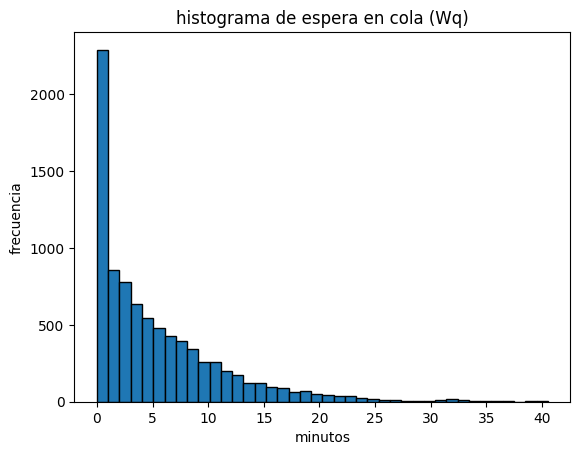

In [31]:
# percentiles y propuesta de SLA
waits = res_base["waits_sample"]
W_all = res_base["W_sample"]

p50 = np.percentile(waits, 50) if waits else 0.0
p90 = np.percentile(waits, 90) if waits else 0.0
p90_W = np.percentile(W_all, 90) if W_all else 0.0

print(f"p50 espera: {p50:.3f} min")
print(f"p90 espera: {p90:.3f} min")
print(f"p90 tiempo en sistema: {p90_W:.3f} min")

# histograma breve de espera en cola
plt.figure()
plt.hist(waits, bins=40, edgecolor="black")
plt.title("histograma de espera en cola (Wq)")
plt.xlabel("minutos")
plt.ylabel("frecuencia")
plt.show()


In [32]:
# escenarios A y B para comparar
escenarios = [
    {"nombre":"base", "lam":0.85, "mu":1.00},
    {"nombre":"A_mayor_demanda", "lam":0.95, "mu":1.00},
    {"nombre":"B_mayor_capacidad", "lam":0.85, "mu":1.10},
]

filas = []
for e in escenarios:
    r = simular_mm1(e["lam"], e["mu"], T, seed=100)
    filas.append({
        "escenario": e["nombre"],
        "lam": e["lam"], "mu": e["mu"],
        "utilizacion": round(r["utilizacion"],4),
        "Wq": round(r["Wq"],4), "W": round(r["W"],4),
        "Lq": round(r["Lq"],4), "L": round(r["L"],4),
        "arrivals": r["arrivals"], "departures": r["departures"]
    })

df = pd.DataFrame(filas)
df


,escenario,lam,mu,utilizacion,Wq,W,Lq,L,arrivals,departures
0,base,0.85,1.0,0.8559,6.3275,7.3314,5.3929,6.2486,8531,8523
1,A_mayor_demanda,0.95,1.0,0.9590,22.8807,23.8864,21.8190,22.7780,9546,9536
2,B_mayor_capacidad,0.85,1.1,0.7888,3.3621,4.2793,2.8910,3.6798,8602,8599


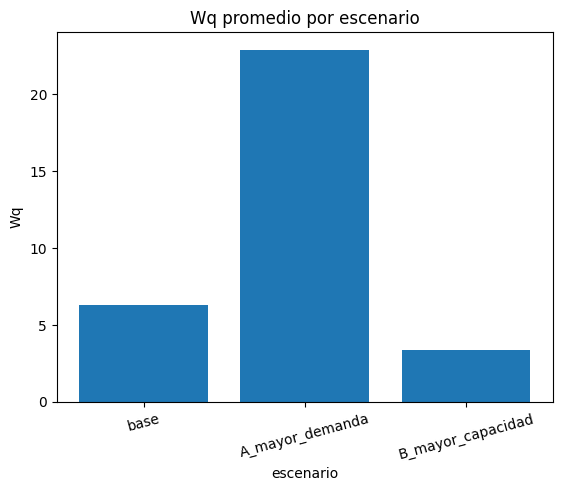

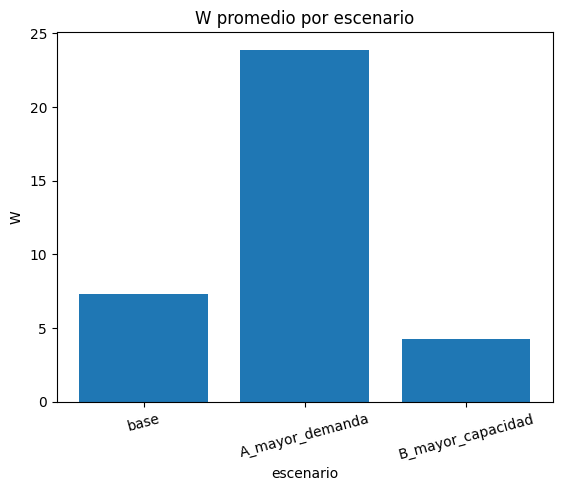

In [36]:
# barras comparativas de Wq por escenario
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df["escenario"], df["Wq"])
plt.title("Wq promedio por escenario")
plt.xlabel("escenario")
plt.ylabel("Wq")
plt.xticks(rotation=15)
plt.show()

plt.figure()
plt.bar(df["escenario"], df["W"])
plt.title("W promedio por escenario")
plt.xlabel("escenario")
plt.ylabel("W")
plt.xticks(rotation=15)
plt.show()


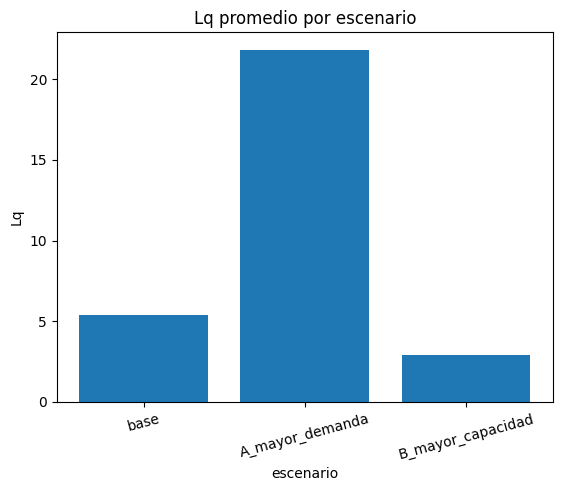

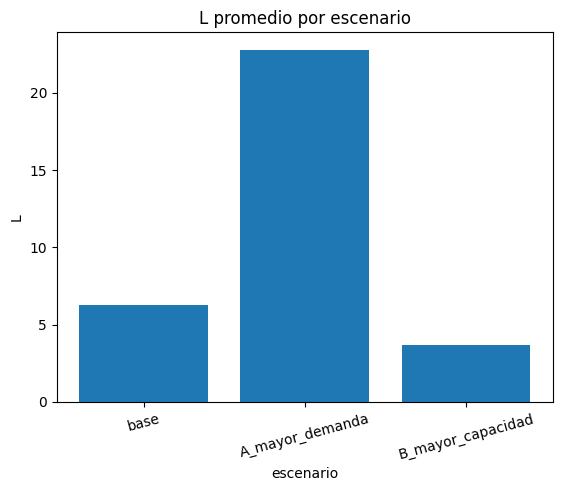

In [37]:
# barras comparativas de Lq y L por escenario
plt.figure()
plt.bar(df["escenario"], df["Lq"])
plt.title("Lq promedio por escenario")
plt.xlabel("escenario")
plt.ylabel("Lq")
plt.xticks(rotation=15)
plt.show()

plt.figure()
plt.bar(df["escenario"], df["L"])
plt.title("L promedio por escenario")
plt.xlabel("escenario")
plt.ylabel("L")
plt.xticks(rotation=15)
plt.show()


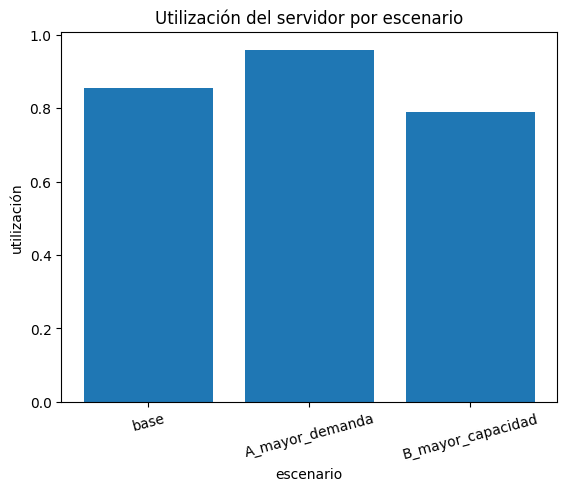

In [38]:
# utilización del servidor por escenario
plt.figure()
plt.bar(df["escenario"], df["utilizacion"])
plt.title("Utilización del servidor por escenario")
plt.xlabel("escenario")
plt.ylabel("utilización")
plt.xticks(rotation=15)
plt.show()


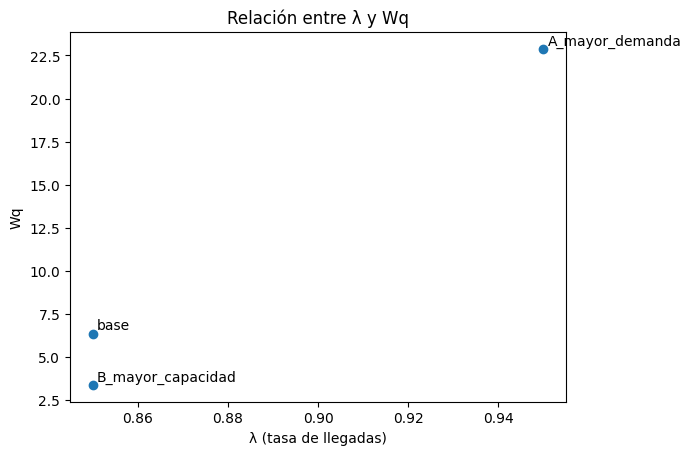

In [39]:
# dispersión lam vs Wq para ver sensibilidad a la carga
plt.figure()
plt.scatter(df["lam"], df["Wq"])
for i, row in df.iterrows():
    plt.annotate(row["escenario"], (row["lam"], row["Wq"]), xytext=(3,3), textcoords="offset points")
plt.title("Relación entre λ y Wq")
plt.xlabel("λ (tasa de llegadas)")
plt.ylabel("Wq")
plt.show()


In [40]:
# tabla con variación porcentual respecto al escenario base
base = df.loc[df["escenario"]=="base"].iloc[0]
cols_cmp = ["utilizacion","Wq","W","Lq","L"]
df_cmp = df.copy()
for c in cols_cmp:
    df_cmp[c+"_vs_base_%"] = 100*(df[c] - base[c]) / base[c]
df_cmp


,escenario,lam,mu,utilizacion,Wq,W,Lq,L,arrivals,departures,utilizacion_vs_base_%,Wq_vs_base_%,W_vs_base_%,Lq_vs_base_%,L_vs_base_%
0,base,0.85,1.0,0.8559,6.3275,7.3314,5.3929,6.2486,8531,8523,0.000000,0.000000,0.000000,0.000000,0.000000
1,A_mayor_demanda,0.95,1.0,0.9590,22.8807,23.8864,21.8190,22.7780,9546,9536,12.045800,261.607270,225.809532,304.587513,264.529655
2,B_mayor_capacidad,0.85,1.1,0.7888,3.3621,4.2793,2.8910,3.6798,8602,8599,-7.839701,-46.865271,-41.630521,-46.392479,-41.110009
